# Image preprocessing notebook

The objective here is to isolate the behaving mouse from its background. Following G. Berman's pipeline:

"To isolate the fly from the background, we apply **Canny’s method for edge detection**, resulting in a binary image
containing the edge positions. We then **morphologically dilate this binary image by a 3x3 square** in order to fill
any spurious holes in the edges and proceed to fill all closed curves. This filled image is then **morphologically
eroded by a square of the same size**, resulting in a **mask**. After applying this mask to the original image, we now
have our segmented image. 
While our **tracking algorithm** ensures that the fly remains within the image boundaries, the **centre of the fly** and the **orientation within the frame vary** over time. Having obtained a sequence of isolated fly images, we next **register them both translationally and rotationally** with **respect to a template image**. The template image is generated by taking a typical image of a fly and then manually ablating the wings and legs digitally.
For our first step, we **rotationally align**. This is achieved through **finding the angle that maximizes the cross-correlation between the magnitudes of the two-dimensional polar Fourier transforms for each image and the template**. Because all translation information appears in the phase of the two-dimensional Fourier transform, this rotational alignment, based only upon the magnitude of the transform, is independent of any initial translations between the images. Accordingly, once rotational alignment is achieved, we can subsequently **register the images translationally via a cross-correlation**."

In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
# from skimage.registration import phase_cross_correlation
# from skimage.transform import warp_polar, rotate, rescale
from skimage.util import img_as_float

import sys
import math
import scipy
import scipy.ndimage.interpolation as ndii
from skimage.feature import register_translation
import pprint
import time

import h5py

In [2]:
root_dir = '/Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_7'
vidcap = cv2.VideoCapture(os.path.join(root_dir,'blackfly_375529_2021-07-25_7_VIDEO.avi'))
success,image = vidcap.read()
count = 0
while count<100:
    cv2.imwrite(os.path.join(root_dir, f'frame_{count}.jpg'), image)     # save frame as JPEG file      
    success,image = vidcap.read()
    print('Read a new frame: ', success)
    count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Text(0.5, 1.0, 'Original Image')

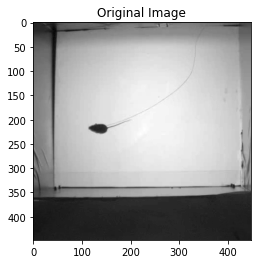

In [79]:
frame = 21090
img = cv2.imread(os.path.join('/Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_2021-07-25_7_frames',
                              f'frame_{frame}.jpg'), 0)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image')

Text(0.5, 1.0, 'Arena ROI')

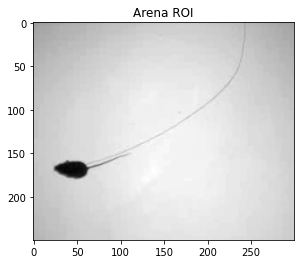

In [72]:
plt.imshow(img[50:300,90:390],cmap = 'gray')
plt.title('Arena ROI')

## Track mouse center coordinates

DLC should perform here as a tracking algorithm, trageting the (x,y) coordinates of the mouse's mid spine. The output should resemble a list of x and y coordinates over time, of equal length to the number of frames in the video.

In [4]:
dlc_train = root_dir+'/pose_Estimation/blackfly_375529_2021-07-25_7_VIDEODLC_resnet50_POSENov30shuffle1_1000.h5'
print(dlc_train)
h5 = h5py.File(dlc_train,'r')

def printname(name):
    print(name)
    
h5.visit(printname)

indices = h5['df_with_missing/table']
(frames, x, y, conf) = np.transpose(np.asarray(
    [(entry[0], entry[1][0], entry[1][1], entry[1][2]) for entry in indices]))

frames = [int(frame) for frame in frames]

/Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_7/pose_Estimation/blackfly_375529_2021-07-25_7_VIDEODLC_resnet50_POSENov30shuffle1_1000.h5
df_with_missing
df_with_missing/_i_table
df_with_missing/_i_table/index
df_with_missing/_i_table/index/abounds
df_with_missing/_i_table/index/bounds
df_with_missing/_i_table/index/indices
df_with_missing/_i_table/index/indicesLR
df_with_missing/_i_table/index/mbounds
df_with_missing/_i_table/index/mranges
df_with_missing/_i_table/index/ranges
df_with_missing/_i_table/index/sorted
df_with_missing/_i_table/index/sortedLR
df_with_missing/_i_table/index/zbounds
df_with_missing/table


### Cropping video frames

In [5]:
def crop_frames(img, xc, yc, fh=120, fw=120):
    # Image shape:
    ih, iw = img.shape
    # Define center coordinates and desired cropping lenght and width
    x, y = int(xc), int(yc)
    h, w = int(fh), int(fw)
    xmin, xmax = int(x-w/2), int(x+w/2)
    ymin, ymax = int(y-h/2), int(y+h/2)
    # Pad in case the borders are surpassed, to keep shape
    top = bottom = left = right = 0
    if ymin<0:
        top = -ymin
    if xmin<0:
        left = -xmin
    if ymax>ih:
        bottom = ymax-ih
    if xmax>iw:
        right = xmax-iw
    pad_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_REPLICATE) #try BORDER_CONSTANT
    # Finally, crop:
    crop_img = pad_img[ymin+top:ymax+top+bottom, xmin+left:xmax+left+right]
    return crop_img

Center: x-135.58946228027344, y-215.68533325195312
(100, 100)


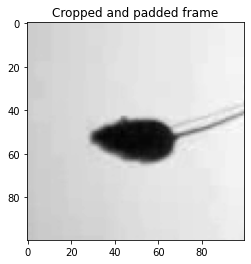

In [80]:
print(f'Center: x-{x[frame]}, y-{y[frame]}')
crop_img = crop_frames(img, x[frame], y[frame], fh=100, fw=100)
plt.imshow(crop_img, cmap='gray')
plt.title('Cropped and padded frame')
print(np.shape(crop_img))

## Opening and closing frames with Canny edge detection
[Link](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123) to understand the steps in Canny edge detection.

In [18]:
def close_edges(img, th1=260, th2=150, kx=3, ky=3, dil_iter=1, close_iter=6):
    edges = cv2.Canny(img,th1,th2)
    kernel = np.ones((kx,ky), np.uint8)
    # img_erosion = cv2.erode(edges, kernel, iterations=1)
    img_dilation = cv2.dilate(edges, kernel, iterations=dil_iter)
    closing = cv2.morphologyEx(img_dilation, cv2.MORPH_CLOSE, kernel, iterations=close_iter)
    closing = (closing > 0).astype(np.uint8)
    return closing

Text(0.5, 1.0, 'Frame mask')

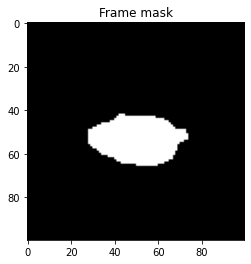

In [86]:
closed_img = close_edges(crop_img, th1=320, th2=270, close_iter=7)
plt.imshow(closed_img, cmap = 'gray')
plt.title('Frame mask')

Text(0.5, 1.0, 'Masked frame')

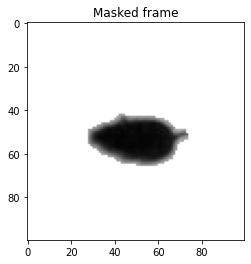

In [87]:
# Mask input image with binary mask - Color background white
crop_img[closed_img==0] = 255 # Optional
plt.imshow(crop_img, cmap='gray')
plt.title('Masked frame')

## Rotationally align the frames with a template image

Useful [link](https://stackoverflow.com/questions/33698068/align-text-for-ocr) to understand polar FFTs in a context of image alignment.

**1)** Compute the magnitude of the FFT of the two images (apply a windowing function first to avoid issues with periodicity of the FFT).
**2)** Compute the log-polar transform of the magnitude of the frequency-domain images (typically a high-pass filter is applied first, but I have not seen its usefulness).
**3)** Compute the cross-correlation (actually phase correlation) between the two. This leads to a knowledge of scale and rotation.
**4)** Apply the scaling and rotation to one of the original input images.
**5)** Compute the cross-correlation (actually phase correlation) of the original input images, after correction for scaling and rotation. This leads to knowledge of the translation.

This works because:
The magnitude of the FFT is translation-invariant, we can solely focus on scaling and rotation without worrying about translation. Note that the rotation of the image is identical to the rotation of the FFT, and that scaling of the image is inverse to the scaling of the FFT.
The log-polar transform converts rotation into a vertical translation, and scaling into a horizontal translation. Phase correlation allows us to determine these translations. Converting them to a rotation and scaling is non-trivial (especially the scaling is hard to get right, but a bit of math shows the way).

### Select template frame

Text(0.5, 1.0, 'Template masked frame')

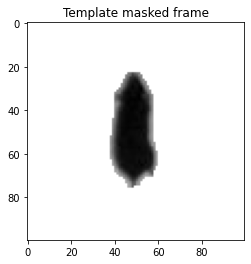

In [88]:
ref_frame = 320
ref_img = cv2.imread(os.path.join(root_dir, f'frame_{ref_frame}.jpg'), 0)
ref_crop_img = crop_frames(ref_img, x[ref_frame], y[ref_frame], fh=100, fw=100)
ref_closed_img = close_edges(ref_crop_img, th1=320, th2=270, close_iter=7)
ref_crop_img[ref_closed_img==0] = 255 # Optional
plt.imshow(ref_crop_img, cmap='gray')
plt.title('Template masked frame')

### Rotationally align current frame, with respect to the template frame
Useful info [here](https://stackoverflow.com/questions/57801071/get-rotational-shift-using-phase-correlation-and-log-polar-transform).

In [22]:
def rotational_shift(image1, image2):
    def compute_angle(image):
        # Convert to grayscale, invert, and Otsu's threshold
        gray = image #cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = 255 - gray
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

        # Find coordinates of all pixel values greater than zero
        # then compute minimum rotated bounding box of all coordinates
        coords = np.column_stack(np.where(thresh > 0))
        angle = cv2.minAreaRect(coords)[-1]

        # The cv2.minAreaRect() function returns values in the range
        # [-90, 0) so need to correct angle
        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = -angle

        # Rotate image to horizontal position 
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
                  borderMode=cv2.BORDER_REPLICATE)

        return (angle, rotated)

    angle1, rotated1 = compute_angle(image1)
    angle2, rotated2 = compute_angle(image2)
        
    # Both angles are positive
    if angle1 >= 0 and angle2 >= 0:
        difference_angle = abs(angle1 - angle2)
    # One positive, one negative
    elif (angle1 <= 0 and angle2 > 0) or (angle1 >= 0 and angle2 < 0) or (angle1 < 0 and angle2 >= 0) or (angle1 < 0 and angle2 >= 0):
        difference_angle = abs(angle1) + abs(angle2)
    # Both negative
    elif angle1 < 0 and angle2 < 0:
        angle1 = abs(angle1)
        angle2 = abs(angle2)
        difference_angle = max(angle1, angle2) - min(angle1, angle2)

    return (difference_angle, rotated1, rotated2)

In [23]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

4.085616588592529


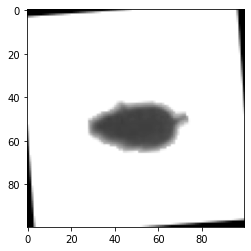

In [89]:
angle, rotated1, rotated2 = rotational_shift(ref_crop_img, crop_img)
print(angle)

# Rotate
rot_img = rotate_image(crop_img, angle)
plt.imshow(rot_img, cmap='gray')

### Crop out edges from image rotation prior to translational shift

In [25]:
# From https://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
def rotatedRectWithMaxArea(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle (maximal area) within the rotated rectangle.
    """
    if w <= 0 or h <= 0:
        return 0,0

    width_is_longer = w >= h
    side_long, side_short = (w,h) if width_is_longer else (h,w)

    # since the solutions for angle, -angle and 180-angle are all the same,
    # if suffices to look at the first quadrant and the absolute values of sin,cos:
    sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
    if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
        # half constrained case: two crop corners touch the longer side,
        #   the other two corners are on the mid-line parallel to the longer line
        x = 0.5*side_short
        wr,hr = (x/sin_a,x/cos_a) if width_is_longer else (x/cos_a,x/sin_a)
    else:
        # fully constrained case: crop touches all 4 sides
        cos_2a = cos_a*cos_a - sin_a*sin_a
        wr,hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a

    return wr,hr

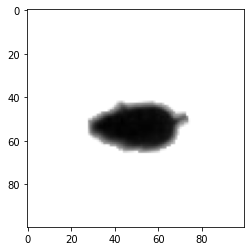

In [90]:
def crop_edges(img, w, h, angle, mult=.90, pix_val=255):
    copy = img.copy()
    bw, bh = rotatedRectWithMaxArea(w, h, angle)
    bw *= mult
    bh *= mult
    pmask = [[i<(w-bw)//2 or i>(w+bw)//2 or j<(h-bh)//2 or j>(h+bh)//2 
              for i in range(np.shape(rot_img)[0])] for j in range(np.shape(rot_img)[1])]
    copy[pmask] = pix_val
    return copy

w = 100
h = 100
curr_frm = crop_edges(rot_img, w, h, angle)
plt.imshow(curr_frm, cmap='gray')

### Align template and current frames translationally

Pixel shift (y,x): [-3.  3.]


(<matplotlib.axes._subplots.AxesSubplot at 0x7fbac1412da0>,
 <matplotlib.image.AxesImage at 0x7fbabef662e8>)

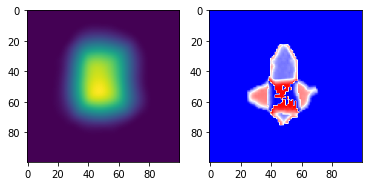

In [91]:
shift, error, diffphase = register_translation(curr_frm, ref_crop_img)
image_product = np.fft.fft2(ref_crop_img) * np.fft.fft2(curr_frm).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
final = scipy.ndimage.shift(curr_frm, -shift, mode='constant', cval=255)
                    
print(f'Pixel shift (y,x): {shift}')
plt.subplot(121),plt.imshow(cc_image.real, cmap='viridis')
plt.subplot(122),plt.imshow(ref_crop_img - final, cmap = 'bwr')

(<matplotlib.image.AxesImage at 0x7fbabdf36c88>,
 Text(0.5, 1.0, 'Final aligned frame'))

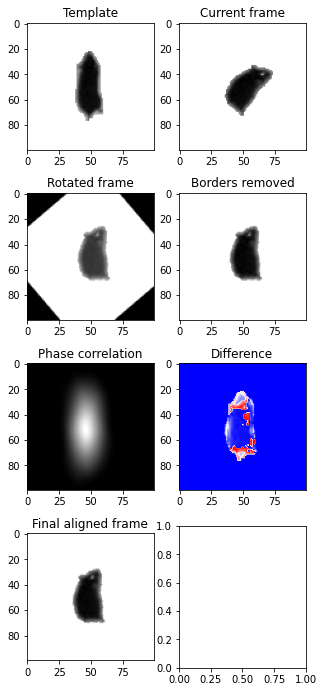

In [28]:
f, axs = plt.subplots(nrows=4, ncols=2, figsize=(5,12))
axs[0,0].imshow(ref_crop_img, cmap='gray'),axs[0,0].set_title('Template')
axs[0,1].imshow(crop_img, cmap = 'gray'),axs[0,1].set_title('Current frame')
axs[1,0].imshow(rot_img, cmap = 'gray'),axs[1,0].set_title('Rotated frame')
axs[1,1].imshow(curr_frm, cmap = 'gray'),axs[1,1].set_title('Borders removed')
axs[2,0].imshow(cc_image.real, cmap = 'gray'),axs[2,0].set_title('Phase correlation')
axs[2,1].imshow(ref_crop_img - final, cmap = 'bwr'),axs[2,1].set_title('Difference')
axs[3,0].imshow(final, cmap = 'gray'),axs[3,0].set_title('Final aligned frame')

## Full function

In [58]:
def process_videos(videos, trackings, root_dir, template_frms=None, temp_frm=320, crop_h=100, crop_w=100, canny_t1=300, canny_t2=220, 
                   morph_iter=7, background=255, min_frm=0, roi_box=[20,330,60,400], min_vid_len=20, share_roi=True, max_frm=None):
    '''
    Preprocesses the raw videos from behavioral experiments (TODO: better description :d)
    The goal is to define an ROI around the animal, proceed to mask the frames and align the orientation
    of its body. The intent of this pipeline is to yield videos that are fit for posture extraction by means
    of PCA.
    TODO: set videos and trackings in the Behav_annotation class when creating training and validation sets.
    '''
    # Exctract a list of full video paths:
    vid_paths = [find_path(vid,root_dir)[-1] for vid in videos]
    
    # Exctract a list of full tracking paths:
    track_paths = [find_path(tck,root_dir)[-1] for tck in trackings]
    assert len(vid_paths) == len(track_paths), 'Number of videos and h5 files do not match'
    # TODO
    # Maybe assert if names match
    # Check if multiple files with the same name exist
    
    # Set template frames to default if they are not provided
    if template_frms is None:
        template_frms = [temp_frm]*len(vid_paths)
        
    # Set the video ROIs
    if share_roi:
        roi_box = [roi_box]*len(vid_paths)
        
    # Output video paths
    out_paths = []
    
    # Iterate over list of video paths:
    for video, dlc_train, template, roi in zip(vid_paths, track_paths, template_frms, roi_box):
        vid_id = vid_paths.index(video)
        vidcap = cv2.VideoCapture(video)
        n_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
        success, image = vidcap.read()
        count = 0
        
        # Create a nested directory for each video:
        vid_tag = '_'.join(os.path.basename(video).split('_')[1:4])
        if not os.path.exists(os.path.join(root_dir, f'{vid_tag}_frames')):
            os.makedirs(os.path.join(root_dir, f'{vid_tag}_frames'))
            print(f'Creating directory: {os.path.join(root_dir, f"{vid_tag}_frames")}')
        
            # Iterate over every frame: 
            # (this is inside the loop, so if this dir exists, it won't write the frames again)
            print(f'Writing {vid_tag} video frames')
            while success:
                # Write the frame - maybe this is avoidable, I just want to keep the frames to assess possible errors
                cv2.imwrite(os.path.join(os.path.join(root_dir, f'{vid_tag}_frames'), f'frame_{count}.jpg'), image)   
                success,image = vidcap.read()
                if count%5000 == 0 and count > 0:
                    print(f'{count} frames written')
                count += 1
            print(f'Extracted {count} frames')
        
        # Load DLC's data:
        print('Loading pose from DLC tracking algorithm')
        h5 = h5py.File(dlc_train,'r')
        # Check h5 file if needed:
#         def printname(name):
#             print(name)
#         h5.visit(printname)
        indices = h5['df_with_missing/table']
        (dlc_frms, x, y, conf) = np.transpose(np.asarray(
            [(entry[0], entry[1][0], entry[1][1], entry[1][2]) for entry in indices]))
        dlc_frms = [int(frame) for frame in dlc_frms]
        # TODO - Check if there are NaNs in the pose file and skip or deal with those values
        # Also smooth the coordinates with a 1€ filter, in case DLC misses some frames
        assert n_frames == len(dlc_frms), f'Length of frames in video and DLC model do not match: {len(count)}=/={len(dlc_frms)}'
        
        # Set the template frame
        print(f'Setting up template frame #{template} for rotational, translational and scaling corrections')
        img = cv2.imread(os.path.join(os.path.join(root_dir, f'{vid_tag}_frames'), f'frame_{template}.jpg'), 0)
        # Crop the frame
        template_img = crop_frames(img, x[template], y[template], fh=crop_h, fw=crop_w)
        # Apply Canny Edge filter and morphologically open and close the edges
        closed_img = close_edges(template_img, th1=canny_t1, th2=canny_t2, close_iter=morph_iter)
        # Apply the mask over the frame
        template_img[closed_img==0] = background
        
        # Set output video parameters:
        print(f'Creating videos from {vid_tag}')
        # Choose codec according to format needed
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        # Setup an output video
        instance = 1
        video = cv2.VideoWriter(os.path.join(os.path.join(root_dir, f'{vid_tag}_frames'), f'{vid_tag}_pose_{instance}.avi'),
                fourcc, 30.0, (crop_w, crop_h))
        vid_len = 0
            
        # Reload the frames and get pose from DLC's h5 file
        if max_frm is None:
            max_frm = n_frames
        for frame in range(min_frm+1, max_frm):
            if frame%5000 == 0 and frame > 0:
                print(f'{frame} frames aligned')
            # Check if the mouse is within the arenas' ROI
            if roi[0]<y[frame]<roi[1] and roi[2]<x[frame]<roi[3]:
                # Reload the frame
                img = cv2.imread(os.path.join(os.path.join(root_dir, f'{vid_tag}_frames'), f'frame_{frame}.jpg'), 0)
                # Crop the frame
                crop_img = crop_frames(img, x[frame], y[frame], fh=crop_h, fw=crop_w)
                # Apply Canny Edge filter and morphologically open and close the edges
                closed_img = close_edges(crop_img, th1=canny_t1, th2=canny_t2, close_iter=morph_iter)
                # Apply the mask over the frame
                crop_img[closed_img==0] = background 
                # Asses the rotational translation between the current frame and the reference frame
                angle, rotated1, rotated2 = rotational_shift(template_img, crop_img)
                rot_img = rotate_image(crop_img, angle)
                # Crop the edges of the rotated image
                curr_frm = crop_edges(rot_img, crop_w, crop_h, angle)
                # Translationally align the frame with the template frame
                shift, error, diffphase = register_translation(curr_frm, template_img)
                image_product = np.fft.fft2(template_img) * np.fft.fft2(curr_frm).conj()
                cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
                final_img = scipy.ndimage.shift(curr_frm, -shift, mode='constant', cval=255)
                # Write video
                final_img = cv2.cvtColor(final_img, cv2.COLOR_GRAY2BGR) #cv2.resize(final_img,(crop_w,crop_h))
                video.write(final_img)
                vid_len += 1
            elif roi[0]<y[frame-1]<roi[1] and roi[2]<x[frame-1]<roi[3] and not(roi[0]<y[frame]<roi[1] and roi[2]<x[frame]<roi[3]) or frame==max_frm-1: # it's true after an ROI frame               
                if vid_len>=min_vid_len:
                    # Write the video
                    print(f'Writing video {os.path.join(os.path.join(root_dir, f"{vid_tag}_frames"), f"{vid_id}_pose_{instance}.avi")} with length: {vid_len}')
                    out_paths.append(os.path.join(os.path.join(root_dir, f'{vid_tag}_frames'), f'{vid_id}_pose_{instance}.avi'))
                    # Advance the loop
                    instance += 1
                # Close the video
                cv2.destroyAllWindows()
                video.release()
                # Create new video
                video = cv2.VideoWriter(os.path.join(os.path.join(root_dir, f'{vid_tag}_frames'), f'{vid_tag}_pose_{instance}.avi'),
                        fourcc, 30.0, (crop_w, crop_h))
                vid_len = 0
                
    return out_paths
   

In [97]:
process_videos(['blackfly_375529_2021-07-25_7_VIDEO.avi'], 
               ['blackfly_375529_2021-07-25_7_VIDEODLC_resnet50_POSENov30shuffle1_1000.h5'],
               root_dir='/Users/joaohenrique/Documents/Clusterolo/KI_paper/data', 
               canny_t1=320, canny_t2=270, min_frm=999, max_frm=10000, roi_box=[50,300,100,350], min_vid_len=30)

Loading pose from DLC tracking algorithm
Setting up template frame #320 for rotational, translational and scaling corrections
Creating videos from 375529_2021-07-25_7
Writing video /Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_2021-07-25_7_frames/0_pose_1.avi with length: 49
Writing video /Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_2021-07-25_7_frames/0_pose_2.avi with length: 54
Writing video /Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_2021-07-25_7_frames/0_pose_3.avi with length: 32
Writing video /Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_2021-07-25_7_frames/0_pose_4.avi with length: 51
Writing video /Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_2021-07-25_7_frames/0_pose_5.avi with length: 61
Writing video /Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_2021-07-25_7_frames/0_pose_6.avi with length: 39
Writing video /Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_2021-07

['/Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_2021-07-25_7_frames/0_pose_1.avi',
 '/Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_2021-07-25_7_frames/0_pose_2.avi',
 '/Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_2021-07-25_7_frames/0_pose_3.avi',
 '/Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_2021-07-25_7_frames/0_pose_4.avi',
 '/Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_2021-07-25_7_frames/0_pose_5.avi',
 '/Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_2021-07-25_7_frames/0_pose_6.avi',
 '/Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_2021-07-25_7_frames/0_pose_7.avi',
 '/Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_2021-07-25_7_frames/0_pose_8.avi',
 '/Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_2021-07-25_7_frames/0_pose_9.avi',
 '/Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_2021-07-25_7_frames/0_pose_10.avi',
 '/Users/

In [35]:
exe = 'blackfly_375529_2021-07-25_7_VIDEODLC_resnet50_POSENov30shuffle1_1000.h5'
rd = '/Users/joaohenrique/Documents/Clusterolo/KI_paper/data'

def find_path(file, root_dir):
    path = []
    for root, dirs, files in os.walk(root_dir):
        for name in files:
            if name == file:
                path.append(os.path.abspath(os.path.join(root, name)))
    return path

path = find_path(exe,rd)
print(path)

['/Users/joaohenrique/Documents/Clusterolo/KI_paper/data/375529_7/pose_estimation/blackfly_375529_2021-07-25_7_VIDEODLC_resnet50_POSENov30shuffle1_1000.h5']


## Test tube

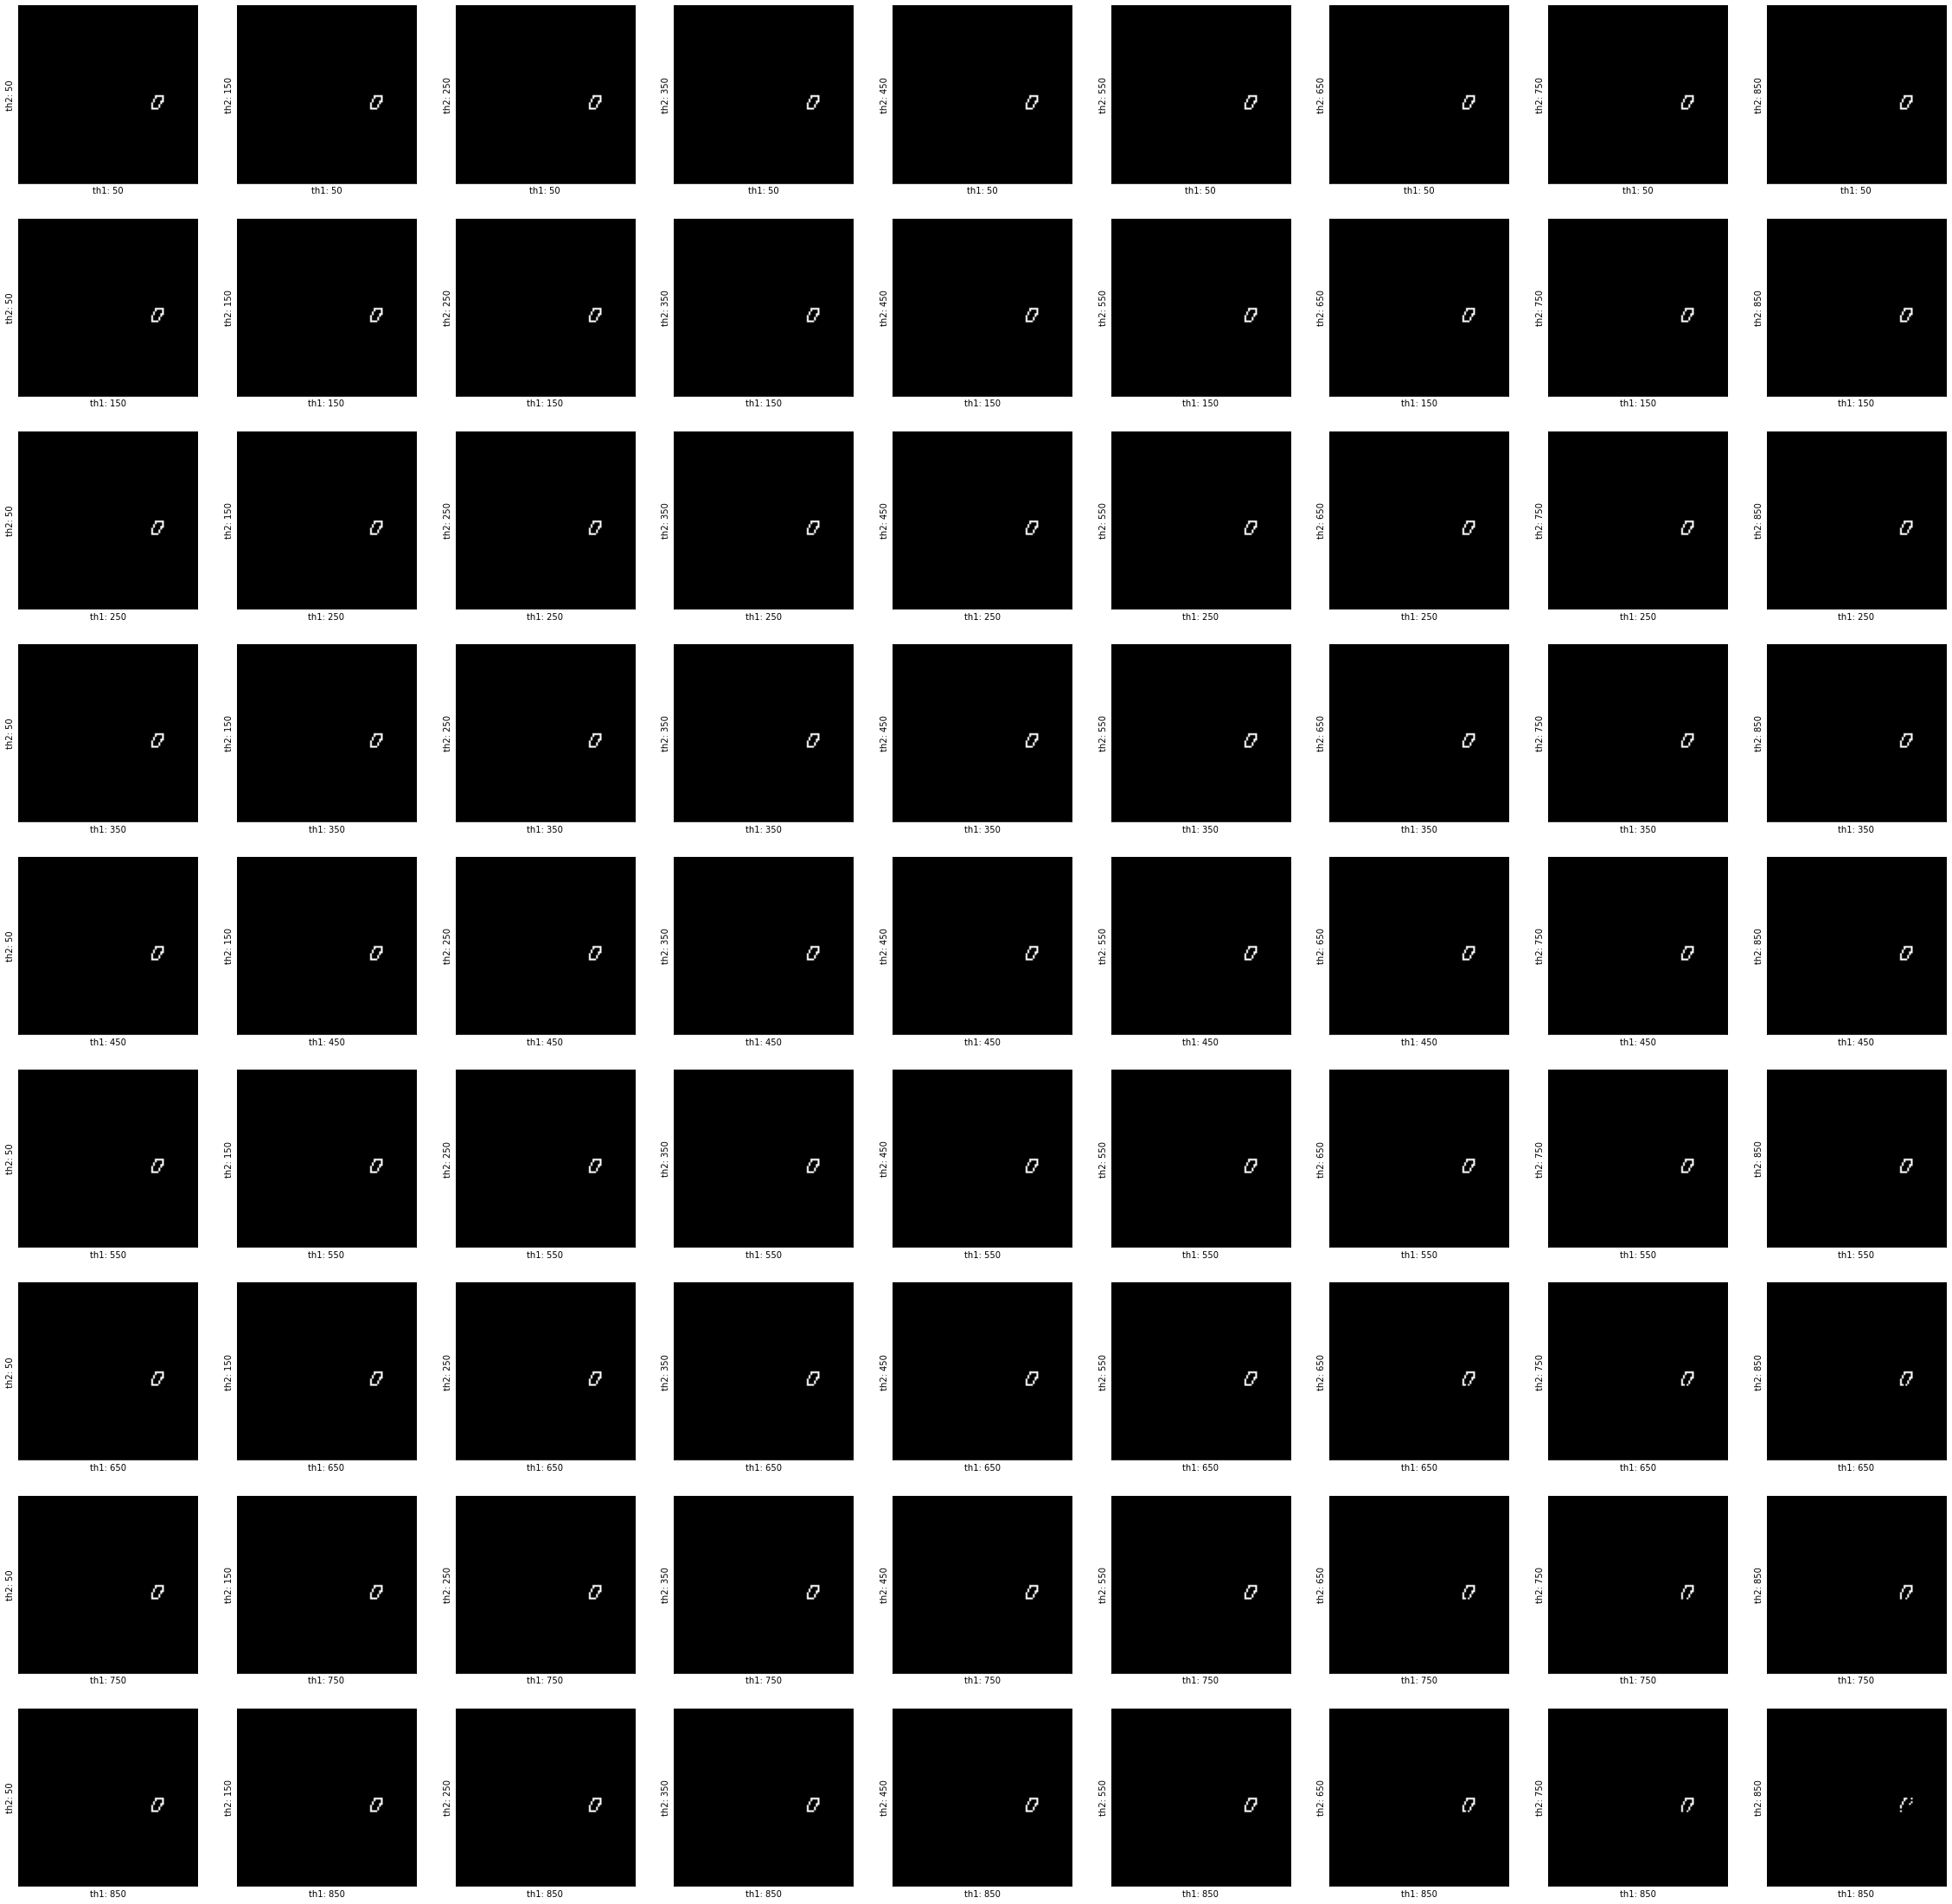

In [158]:
%matplotlib inline
th1 = np.arange(50, 900,100)
th2 = np.arange(50, 900,100)
fig, ax = plt.subplots(nrows=len(th1), ncols=len(th2), figsize=(40,40))
k = 1
for i in range(len(th1)):
    for j in range(len(th2)):
        edges = cv2.Canny(crop_img,th1[i],th2[j])
        plt.subplot(len(th1),len(th2),k)
        plt.xlabel(f'th1: {th1[i]}', fontsize=10)
        plt.ylabel(f'th2: {th2[j]}', fontsize=10)
        plt.imshow(edges,cmap = 'gray')
        plt.xticks([])
        plt.yticks([])
        k += 1
plt.savefig('/Users/joaohenrique/Documents/Clusterolo/KI_paper/results/thresholds.png')

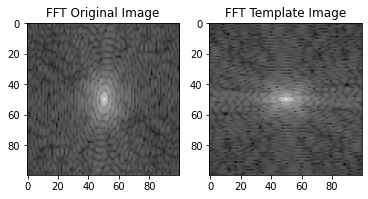

In [92]:
# Compute 2D FFTs:
# TODO: Check out windowing functions to apply prior to the FFT 
# (https://en.wikipedia.org/wiki/Window_function#Spectral_analysis)
fft = np.fft.fftshift(np.fft.fft2(crop_img))
ref_fft = np.fft.fftshift(np.fft.fft2(ref_crop_img))
fft = np.log(np.abs(fft))
ref_fft = np.log(np.abs(ref_fft))
plt.subplot(1,2,1)
plt.imshow(fft, cmap = 'gray')
plt.title('FFT Original Image')
plt.subplot(1,2,2)
plt.imshow(ref_fft, cmap = 'gray')
plt.title('FFT Template Image')
plt.show()

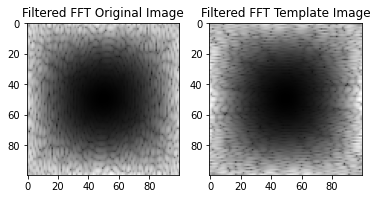

In [95]:
# Apply high pass filter and proceed to compute log-polar transform
filter_fft = fft * prepareHighPassFilter(fft)
ref_filter_fft = ref_fft * prepareHighPassFilter(ref_fft)
plt.subplot(1,2,1)
plt.imshow(filter_fft, cmap = 'gray')
plt.title('Filtered FFT Original Image')
plt.subplot(1,2,2)
plt.imshow(ref_filter_fft, cmap = 'gray')
plt.title('Filtered FFT Template Image')
plt.show()

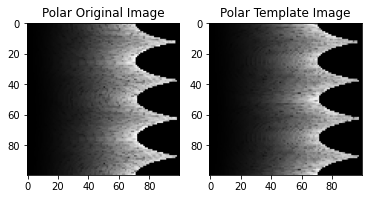

In [96]:
# img -> your image 
h, w = filter_fft.shape[:2]
img_center = (h//2, w//2)
img_radius = math.hypot(h//2, w//2)

cart_2_polar_flag = cv2.WARP_FILL_OUTLIERS
polar = cv2.linearPolar(filter_fft, img_center, img_radius, cart_2_polar_flag)
ref_polar = cv2.linearPolar(ref_filter_fft, img_center, img_radius, cart_2_polar_flag)

plt.subplot(1,2,1)
plt.imshow(polar, cmap = 'gray')
plt.title('Polar Original Image')
plt.subplot(1,2,2)
plt.imshow(ref_polar, cmap = 'gray')
plt.title('Polar Template Image')
plt.show()

-3.069278225539654


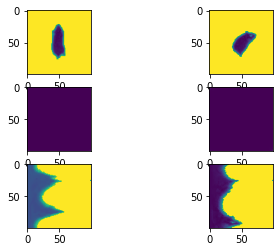

In [30]:
# Test
base_img = ref_crop_img
base_img = np.float32(ref_crop_img)

(h, w) = base_img.shape
(cX, cY) = (w // 2, h // 2)

angle = 38
M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
curr_img = cv2.warpAffine(base_img, M, (w, h))
curr_img = np.float32(crop_img)

plt.subplot(3,2,1)
plt.imshow(base_img)
plt.subplot(3,2,2)
plt.imshow(curr_img)

fft_img = np.absolute(np.fft.fft2(base_img))
curr_fft = np.absolute(np.fft.fft2(curr_img))

plt.subplot(3,2,3)
plt.imshow(fft_img)
plt.subplot(3,2,4)
plt.imshow(curr_fft)

base_polar = cv2.linearPolar(base_img,(cX, cY), min(cX, cY), 0)
curr_polar = cv2.linearPolar(curr_img,(cX, cY), min(cX, cY), 0) 

plt.subplot(3,2,5)
plt.imshow(base_polar)
plt.subplot(3,2,6)
plt.imshow(curr_polar)

(sx, sy), sf = cv2.phaseCorrelate(base_polar, curr_polar)

rotation = -sy / h * 360;
print(rotation)

In [ ]:
timeStart = time.time()
# Step 1 - Apply FFT on both images and get their magnitude spectrums
# image (we are looking for), lets call it original
imgOriginal, imgOriginalFft, imgOriginalMags = readImage(ref_crop_img)
# image (we are searching in), lets call it transformed
imgTransformed, imgTransformedFft, imgTransformedMags = readImage(np.float32(crop_img)) #curr_img np.float32(crop_img)

# Step 2 - Apply highpass filter on their magnitude spectrums
highPassFilter = prepareHighPassFilter(imgOriginalMags)
imgOriginalMagsFilter = imgOriginalMags * highPassFilter
imgTransformedMagsFilter = imgTransformedMags * highPassFilter

# Step 3 - Convert magnitudes both images to log-polar coordinates
# Step 3.1 - Precompute parameters (both images have the same dimensions)
centerTrans, angleStep, logBase = computeLogPolarParameters(imgOriginalMagsFilter)
imgOriginalLogPolar = convertToLogPolar(imgOriginalMagsFilter, centerTrans, angleStep, logBase, polarMode)
imgTransformedLogPolar = convertToLogPolar(imgTransformedMagsFilter, centerTrans, angleStep, logBase, polarMode)

# Step 3.1 - Apply FFT on magnitude spectrums in log polar coordinates (in this case, not using FFT shift as it leads to computing [180-angle] results)
imgOriginalLogPolarComplex = cv2.dft(np.float32(imgOriginalLogPolar),flags = cv2.DFT_COMPLEX_OUTPUT)
imgTransformedLogPolarComplex = cv2.dft(np.float32(imgTransformedLogPolar),flags = cv2.DFT_COMPLEX_OUTPUT)

# Step 4 - Apply phase corelation on both images (FFT applied on log polar images) to retrieve rotation (angle) and scale factor
angle, scale = phaseCorrelation(imgOriginalLogPolarComplex, imgTransformedLogPolarComplex)
# Step 4.1 Convert to degrees based on formula in paper (26) and adjust it to (-pi/2, pi/2) range
angleDeg = -(float(angle) * 180.0 ) / imgOriginalLogPolarComplex.shape[0]
if angleDeg < - 45:
    angleDeg += 180
else:
    if angleDeg > 90.0:
        angleDeg -= 180

# Step 4.2 Calculate scale factor based on formula in paper (25)
scaleFactor = logBase ** scale

# Step 5 - Apply rotation and scaling on transformed image
transformMatrix = cv2.getRotationMatrix2D((centerTrans[0], centerTrans[1]), angleDeg, scaleFactor)
imgTransformedNew = cv2.warpAffine(imgTransformed, transformMatrix, (imgTransformed.shape[1], imgTransformed.shape[0]) )

# Step 6 - Apply phase corelation on both images to retrieve translation
# Step 6.1 Apply FFT to newly created transformed image
imgTransformedNewFft, imgTransformedNewftShifted = calculateFft(imgTransformedNew)
# Step 6.2 - Use phase corelation to get translation coordinates
y, x = phaseCorrelation(imgTransformedNewftShifted, imgOriginalFft)
# Step 6.3 Apply translation on the final image
if x > imgOriginal.shape[0] // 2:
    x -= imgOriginal.shape[0]
if y > imgOriginal.shape[1] // 2:
    y -= imgOriginal.shape[1]

translationMatrix = np.float32([[1,0,-x],[0,1,-y]])
imgFinal = cv2.warpAffine(imgTransformedNew, translationMatrix, (imgTransformed.shape[1], imgTransformed.shape[0]))
timeEnd = time.time()

In [94]:
# global constants
RE_IDX = 0
IM_IDX = 1
ROWS_AXIS = 0
COLS_AXIS = 1
polarMode = "spline"
noiseMode = "none" # "gaussian", "s&p", "none"
noiseIntensity = {'sigma' : 2, 'mean' : 0, 'whiteThreshold' : 0.01, 'blackThreshold' : 0.99}
resultsComparation = True

# reads image, runs FFT and returns FFT image + its magnitude spectrum
def readImage(img):
    imgData = img # 0 means Grayscale
    imgData = addNoiseToImage(imgData, noiseMode, noiseIntensity)
    imgFft, imgFftShifted = calculateFft(imgData) # FFT of the image
    imgMags = cv2.magnitude(imgFftShifted[:,:,RE_IDX],imgFftShifted[:,:,IM_IDX])
    return (imgData, imgFftShifted, imgMags)


# applies highpass filter and returns the image
# H(col, row) = (1.0 - X(col, row)) * (2.0 - X(col, row)), row and col have to be transformed to range <-pi/2, pi/2>
# X(valX, valY) = cos(pi * valX) * cos(pi * valY), both valX and valY in range <-pi/2, pi/2>
def prepareHighPassFilter(img):
    pi2 = math.pi / 2.0
    # transform number of rows to <-pi/2,pi/2> range and calculate cos for each element
    rows = np.cos(np.linspace(-pi2, pi2, img.shape[0]))
    # transform number of cols to <-pi/2,pi/2> range and calculate cos for each element
    cols = np.cos(np.linspace(-pi2, pi2, img.shape[1]))
    # creates matrix the whole image
    x = np.outer( rows, cols)
    return (1.0 - x) * (2.0 - x)


# this function will calculates parameters for log polar transformation
# (center of transformation, angle step and log base)
def computeLogPolarParameters(img):
    # Step 1 - Get center of the transformation
    centerTrans = [math.floor((img.shape[ROWS_AXIS] + 1) / 2), math.floor((img.shape[COLS_AXIS] + 1 ) / 2)]
    # Step 2 - Estimate dimensions of final image after discrete log-polar transformation
    # num of columns = log(radius)
    # num of rows = angle in radius (0, 2pi)
    maxDiff = np.maximum(centerTrans, np.asarray(img.shape) - centerTrans)
    maxDistance = ((maxDiff[0] ** 2 + maxDiff[1] ** 2 ) ** 0.5)
    dimsLogPolar = [0,0]
    dimsLogPolar[COLS_AXIS] = img.shape[COLS_AXIS]
    dimsLogPolar[ROWS_AXIS] = img.shape[ROWS_AXIS]
    # Step 2.1 - Estimate log base
    logBase = math.exp(math.log(maxDistance) / dimsLogPolar[COLS_AXIS])
    # Step 3 - Calculate step for angle in log polar coordinates
    angleStep = ( 1.0 * math.pi ) / dimsLogPolar[ROWS_AXIS]
    return (centerTrans, angleStep, logBase)

# converts image to its log polar representation
# returns the log polar representation and log base
def convertToLogPolar(img, centerTrans, angleStep, logBase, mode = "nearest"):
    if mode == "nearest":
        # Step 1 - Initialize transformed image
        transformedImage = np.zeros(img.shape, dtype = img.dtype)
        # Step 2 - Apply reverse log polar transformation
        for radius in range(img.shape[COLS_AXIS]): # start with radius, because calculating exponential power is time consuming
            actRadius = logBase ** radius
            for angle in range(img.shape[ROWS_AXIS]):
                anglePi =  angle * angleStep
                # calculate euclidian coordinates (source: https://en.wikipedia.org/wiki/Log-polar_coordinates)
                row = int(centerTrans[ROWS_AXIS] + actRadius * math.sin(anglePi))
                col = int(centerTrans[COLS_AXIS] + actRadius * math.cos(anglePi))
                # copy pixel from the location to log polar image
                if 0 <= row < img.shape[ROWS_AXIS] and 0 <= col < img.shape[COLS_AXIS]:
                    transformedImage[angle, radius] = img[row, col]

        return transformedImage
    else:
        print("Base: " + str(logBase))
        # create matrix with angles
        anglesMap = np.zeros(img.shape, dtype=np.float64)
        # each column has 0 in its first row and -pi in its last row
        anglesVector = -np.linspace(0, np.pi, img.shape[0], endpoint=False)
        # initialize it by columns using the same vector
        anglesMap.T[:] = anglesVector
        # create matrix with radii
        radiusMap = np.zeros(img.shape, dtype=np.float64)
        # each line contains a vector with numbers from  in (0, cols) to power logBase
        radiusVector = np.power(logBase, np.arange(img.shape[1], dtype=np.float64)) - 1.0
        # initialize it by rows using the same vector
        radiusMap[:] = radiusVector
        # calculate x coordinates (source: https://en.wikipedia.org/wiki/Log-polar_coordinates)
        x = radiusMap * np.sin(anglesMap) + centerTrans[1]
        # calculate y coordinates (source: https://en.wikipedia.org/wiki/Log-polar_coordinates)
        y = radiusMap * np.cos(anglesMap) + centerTrans[0]
        # initialize final image
        outputImg = np.zeros(img.shape)
        # use spline interpolation to map pixels from original image to calculated coordinates
        ndii.map_coordinates(img, [x, y], output=outputImg)
        return outputImg


# computes phase correlation and returns position of pixel with highest value (row, column)
def phaseCorrelation(img_orig, img_transformed):
    # Step 3.1 - Initialize complex conjugates for original image and magnitudes
    orig_conj = np.copy(img_orig)
    orig_conj[:,:,IM_IDX] = -orig_conj[:,:,IM_IDX]
    orig_mags = cv2.magnitude(img_orig[:,:,RE_IDX],img_orig[:,:,IM_IDX])
    img_trans_mags = cv2.magnitude(img_transformed[:,:,RE_IDX],img_transformed[:,:,IM_IDX])
    # Step 3.2 - Do deconvolution
    # multiplication compex numbers ===> (x + yi) * (u + vi) = (xu - yv) + (xv + yu)i
    # deconvolution ( H* x G ) / |H x G|
    realPart = (orig_conj[:,:,RE_IDX] * img_transformed[:,:,RE_IDX] - orig_conj[:,:,IM_IDX] * img_transformed[:,:,IM_IDX]) / (orig_mags * img_trans_mags)
    imaginaryPart = (orig_conj[:,:,RE_IDX] * img_transformed[:,:,IM_IDX] + orig_conj[:,:,IM_IDX] * img_transformed[:,:,RE_IDX]) / ( orig_mags * img_trans_mags)
    result = np.dstack((realPart, imaginaryPart))
    result_idft = cv2.idft(result)
    # Step 3.3 - Find Max value (angle and scaling factor)
    result_mags = cv2.magnitude(result_idft[:,:,RE_IDX],result_idft[:,:,IM_IDX])
    return np.unravel_index( np.argmax(result_mags), result_mags.shape)


# adds artifical noise to images
def addNoiseToImage(img, noise, noiseIntensity):
    if noise == 's&p':
        print("Adding S&P Noise: wT = " + str(noiseIntensity['whiteThreshold']) + "; bT = " + str(noiseIntensity['blackThreshold']))
        # generate probabilities from uniform distribution
        distData = np.random.uniform(0.0, 1.0, img.shape).reshape(img.shape)
        # set ones below whiteThreshold to white
        img[distData < noiseIntensity['whiteThreshold']] = 255
        # set ones above blackThreshold to black
        img[distData > noiseIntensity['blackThreshold']] = 0
        return img
    else:
        if noise == 'gaussian':
            print("Adding Gaussian noise: sigma = " + str(noiseIntensity['sigma']) + '; mean = ' + str(noiseIntensity['mean']))
            return noiseIntensity['sigma'] * np.random.randn(img.shape[0], img.shape[1]) + img + noiseIntensity['mean']
        else:
            return img


# Central point for running FFT
def calculateFft(img):
    imgTmp  = np.float32(img)
    # FFT of the image
    imgFft = cv2.dft(imgTmp,flags = cv2.DFT_COMPLEX_OUTPUT)
    # the FFT shift is needed in order to center the results
    imgFftShifted = np.fft.fftshift(imgFft)
    return (imgFft, imgFftShifted)


Base: 1.0435057584892071
Base: 1.0435057584892071
Angle = -0.0 Deg
Scale = 1.0
Translation
X = -8
Y = -8
Time = 0.043192148208618164


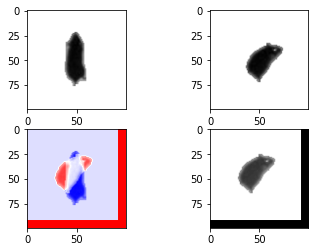

In [29]:
timeStart = time.time()
# Step 1 - Apply FFT on both images and get their magnitude spectrums
# image (we are looking for), lets call it original
imgOriginal, imgOriginalFft, imgOriginalMags = readImage(np.float32(ref_crop_img))
# image (we are searching in), lets call it transformed
imgTransformed, imgTransformedFft, imgTransformedMags = readImage(np.float32(crop_img)) #curr_img np.float32(crop_img)

# Step 2 - Apply highpass filter on their magnitude spectrums
highPassFilter = prepareHighPassFilter(imgOriginalMags)
imgOriginalMagsFilter = imgOriginalMags * highPassFilter
imgTransformedMagsFilter = imgTransformedMags * highPassFilter

# Step 3 - Convert magnitudes both images to log-polar coordinates
# Step 3.1 - Precompute parameters (both images have the same dimensions)
centerTrans, angleStep, logBase = computeLogPolarParameters(imgOriginalMagsFilter)
imgOriginalLogPolar = convertToLogPolar(imgOriginalMagsFilter, centerTrans, angleStep, logBase, polarMode)
imgTransformedLogPolar = convertToLogPolar(imgTransformedMagsFilter, centerTrans, angleStep, logBase, polarMode)

# Step 3.1 - Apply FFT on magnitude spectrums in log polar coordinates (in this case, not using FFT shift as it leads to computing [180-angle] results)
imgOriginalLogPolarComplex = cv2.dft(np.float32(imgOriginalLogPolar),flags = cv2.DFT_COMPLEX_OUTPUT)
imgTransformedLogPolarComplex = cv2.dft(np.float32(imgTransformedLogPolar),flags = cv2.DFT_COMPLEX_OUTPUT)

# Step 4 - Apply phase corelation on both images (FFT applied on log polar images) to retrieve rotation (angle) and scale factor
angle, scale = phaseCorrelation(imgOriginalLogPolarComplex, imgTransformedLogPolarComplex)
# Step 4.1 Convert to degrees based on formula in paper (26) and adjust it to (-pi/2, pi/2) range
angleDeg = -(float(angle) * 180.0 ) / imgOriginalLogPolarComplex.shape[0]
if angleDeg < - 45:
    angleDeg += 180
else:
    if angleDeg > 90.0:
        angleDeg -= 180

# Step 4.2 Calculate scale factor based on formula in paper (25)
scaleFactor = logBase ** scale

# Step 5 - Apply rotation and scaling on transformed image
transformMatrix = cv2.getRotationMatrix2D((centerTrans[0], centerTrans[1]), angleDeg, scaleFactor)
imgTransformedNew = cv2.warpAffine(imgTransformed, transformMatrix, (imgTransformed.shape[1], imgTransformed.shape[0]) )

# Step 6 - Apply phase corelation on both images to retrieve translation
# Step 6.1 Apply FFT to newly created transformed image
imgTransformedNewFft, imgTransformedNewftShifted = calculateFft(imgTransformedNew)
# Step 6.2 - Use phase corelation to get translation coordinates
y, x = phaseCorrelation(imgTransformedNewftShifted, imgOriginalFft)
# Step 6.3 Apply translation on the final image
if x > imgOriginal.shape[0] // 2:
    x -= imgOriginal.shape[0]
if y > imgOriginal.shape[1] // 2:
    y -= imgOriginal.shape[1]

translationMatrix = np.float32([[1,0,-x],[0,1,-y]])
imgFinal = cv2.warpAffine(imgTransformedNew, translationMatrix, (imgTransformed.shape[1], imgTransformed.shape[0]))
timeEnd = time.time()

# Step 7 - Return final results (rotation, scale factor, translation)
print("Angle = " + str(angleDeg) + " Deg")
print("Scale = " + str(scaleFactor))
print("Translation")
print("X = " + str(-x))
print("Y = " + str(-y))
print("Time = " + str(timeEnd - timeStart))

if resultsComparation:
    plt.subplot(221),plt.imshow(imgOriginal, cmap = 'gray')
    plt.subplot(222),plt.imshow(imgTransformed, cmap = 'gray')
    plt.subplot(223),plt.imshow(imgOriginal - imgFinal, cmap = 'bwr')
    plt.subplot(224),plt.imshow(imgFinal, cmap = 'gray')
    plt.show()
else:
    plt.subplot(521),plt.imshow(imgOriginal, cmap = 'gray')
    plt.subplot(522),plt.imshow(imgTransformed, cmap = 'gray')
    plt.subplot(523),plt.imshow(imgOriginalMagsFilter, cmap = 'gray')
    plt.subplot(524),plt.imshow(imgTransformedMagsFilter, cmap = 'gray')
    plt.subplot(525),plt.imshow(imgOriginalLogPolar, cmap = 'gray')
    plt.subplot(526),plt.imshow(imgTransformedLogPolar, cmap = 'gray')
    plt.subplot(527),plt.imshow(imgTransformedNew, cmap = 'gray')
    plt.subplot(528),plt.imshow(imgOriginal - imgFinal, cmap = 'bwr')
    plt.subplot(529),plt.imshow(imgFinal, cmap = 'gray')
    plt.show()

## Experiments

In [ ]:
from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar, rotate, rescale
from skimage.util import img_as_float

radius = 705
angle = 35
image = img_as_float(ref_crop_img)
rotated = img_as_float(crop_img)
image_polar = warp_polar(image, multichannel=True)
rotated_polar = warp_polar(rotated, multichannel=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Original")
ax[0].imshow(image)
ax[1].set_title("Rotated")
ax[1].imshow(rotated)
ax[2].set_title("Polar-Transformed Original")
ax[2].imshow(image_polar)
ax[3].set_title("Polar-Transformed Rotated")
ax[3].imshow(rotated_polar)
plt.show()

shifts, error, phasediff = phase_cross_correlation(image_polar, rotated_polar)
print("Expected value for counterclockwise rotation in degrees: "
      f"{angle}")
print("Recovered value for counterclockwise rotation: "
      f"{shifts[0]}")

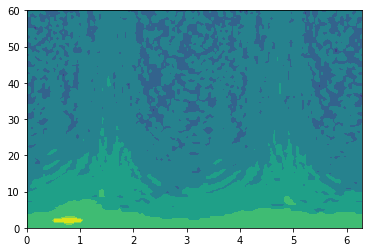

In [36]:
f = np.fft.fft2(ref_crop_img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20 * np.log(np.abs(fshift))

def transform_data(m):
    dpix, dpiy = m.shape
    x_c, y_c = np.unravel_index(np.argmax(m), m.shape)
    angles = np.linspace(0, np.pi*2, min(dpix, dpiy))
    mrc = min(abs(x_c - dpix), abs(y_c - dpiy), x_c, y_c)
    radiuses = np.linspace(0, mrc, max(dpix, dpiy))
    A, R = np.meshgrid(angles, radiuses)
    X = R * np.cos(A)
    Y = R * np.sin(A)
    return A, R, m[X.astype(int) + mrc - 1, Y.astype(int) + mrc - 1]

angles, radiuses, m = transform_data(magnitude_spectrum)
plt.contourf(angles, radiuses, m)

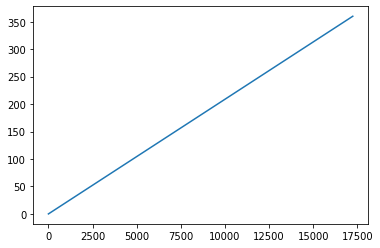

In [47]:
c = np.mean(m, axis=1)
sample_angles = np.linspace(0,  2 * np.pi, c.sum(axis=0)) / np.pi*180
turn_angle_in_degrees = 90 - sample_angles[np.argmax(c.sum(axis=0))]

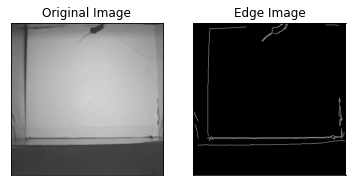

In [31]:
frame = 47

img = cv2.imread(os.path.join(root_dir, f'frame_{frame}.jpg'))
edges = cv2.Canny(img,100,200)
plt.subplot(1,2,1)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image')
plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# Set frame limits
top, right, bottom, left = 10, 450+10, 450+10, 10  # Sample values.

input_video = cv2.VideoCapture('Sample_Vid.mp4')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_movie = cv2.VideoWriter('videoPrueba.avi', fourcc, 30, (450, 450))

while True:
    ret, frame = input_video.read()

    if not ret:
        break

    # Following crop assumes the video is colored, 
    # in case it's Grayscale, you may use: crop_img = frame[top:bottom, left:right]  
    crop_img = frame[top:bottom, left:right, :]

    output_movie.write(crop_img)